# Find identity term matches in data

See process_data.py

In [1]:
# Load incels data
import pandas as pd
import csv

path = '../../data/incels/all_comments.csv'
# data = pd.read_csv(path, engine='python', on_bad_lines=lambda x: print(x))
data = pd.read_csv(path, engine='python', on_bad_lines=lambda row: row[:-2].append(' '.join(row[-2:]))) # combine last 2 elements in a line mentioning Gulag
data['parsed_date'] = pd.to_datetime(data.date, errors='coerce') # "yesterday" etc not handled
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6248230 entries, 0 to 6248229
Data columns (total 7 columns):
 #   Column       Dtype         
---  ------       -----         
 0   type         object        
 1   forum        object        
 2   thread       object        
 3   username     object        
 4   date         object        
 5   content      object        
 6   parsed_date  datetime64[ns]
dtypes: datetime64[ns](1), object(6)
memory usage: 333.7+ MB


## NetMapper identity term lists

### generic_agents-identity 2021 file

In [2]:
# Load identity terms
import pandas as pd

nm_identities_path = '../resources/generic_agents-identity_v15_2021_10_15.xlsx'
multi_identities = pd.read_excel(nm_identities_path)
multi_identities.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19887 entries, 0 to 19886
Columns: 156 entries, Akan to Category 4
dtypes: float64(56), int64(1), object(99)
memory usage: 23.7+ MB


In [3]:
# Filter to English, remove duplicates
cols = multi_identities.columns.tolist()
en_identities = multi_identities[cols[cols.index('English'):]]
en_identities['term'] = en_identities['English'].str.lower()
en_identities.drop_duplicates(subset='term', inplace=True)
en_identities.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19035 entries, 0 to 19886
Data columns (total 44 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   English          19035 non-null  object 
 1   conceptTo        19035 non-null  object 
 2   metaOntology     19035 non-null  object 
 3   nodeType         0 non-null      float64
 4   Category 1       9703 non-null   object 
 5   Category 2       911 non-null    object 
 6   Category 3       18929 non-null  object 
 7   Country          4712 non-null   object 
 8   First Name       0 non-null      float64
 9   Last Name        0 non-null      float64
 10  Gender           759 non-null    object 
 11  Suffix           0 non-null      float64
 12  Language         0 non-null      float64
 13  Acronym          336 non-null    object 
 14  Valence          19035 non-null  object 
 15  Evaluation       19035 non-null  int64  
 16  Potency          10 non-null     float64
 17  Activity    

/tmp/ipykernel_1221270/3338936415.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  en_identities['term'] = en_identities['English'].str.lower()
/tmp/ipykernel_1221270/3338936415.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  en_identities.drop_duplicates(subset='term', inplace=True)


In [3]:
en_identities['Gender'].value_counts()

female     364
male       341
neutral     49
yes          5
Name: Gender, dtype: int64

In [4]:
en_identities['Political Role'].value_counts()

Minister            391
Governor             63
President            58
Diplomat             51
Prime Minister       31
MP                   31
Vice President       26
Mayor                24
Leader               21
Attorney_General     16
Prince               15
MFA                  12
Secretary             9
Vice-President        7
Queen                 7
Princess              6
Vice Premier          4
Congressman           4
King                  3
Royalty               2
Lt_Governor           2
PM                    2
Senator               1
Name: Political Role, dtype: int64

In [7]:
en_identities['Religious Role '].value_counts()

Sheik         21
bishop        16
Archbishop    13
Priest        12
Pope           7
Rabbi          5
Sheikh         2
archbishop     1
Name: Religious Role , dtype: int64

In [9]:
pd.set_option('display.max_rows', None)
en_identities['Category 1'].value_counts()

nationality                4013
Celebrity_Politician        989
ethnic_group                804
military                    694
abusive                     414
scientist                   283
law_enforcement             231
criminal                    198
medical                     182
legal                       169
religious                   146
athlete                     141
religious_leader            135
manager                     105
journalism                  103
student                      84
aristocrat                   76
musician                     73
family_adult_male            72
family_adult_female          71
writer                       61
location_identity            60
stopword                     55
child                        53
kin                          50
artist                       48
entertainer                  41
family_child_female          38
leader                       35
family_child_male            32
sportsperson                 30
Calebrit

In [10]:
en_identities['Category 2'].value_counts()

Native American    644
family_female      118
family_male        109
family-child        17
attacker            10
family_adult         9
defender             2
cyber_actor          2
Name: Category 2, dtype: int64

In [11]:
en_identities['Category 3'].value_counts()

identity    18929
Name: Category 3, dtype: int64

#### Check if terms are in the list

In [25]:
# From WebSci 2020 paper, LGBTQ+ movement dissertation chapter
terms = ['gurl', 'lgbt', 'lgbtq', 'genderfluid', 'gender-fluid', 'gender fluid', 'straight', 'cisgender', 'cis', 
         'asexual', 'aro-ace', 'aro ace', 'aro/ace', 'mtf', 'ftm', 
         'neurodivergent', 'neurodiversity', 'autism', 'autist', 'autistic','mental health', 'adhd', 'dyslexia', 'dyslexic', 
         "asperger's", "aspergers", 'asperger', 'savant', 'intellectual disability', 'bipolar', 'schizophrenia', 'ocd', 'antisocial', 
         'obsessive-compulsive', 'obsessive compulsive', 'disability', 'disabilities', 'disabled', 'anxiety disorder', 'retarded', 'depression',
        'depressive', 'sandnigger', 'sandniggers']
for term in terms:
    print(term, term in en_identities.term.tolist())

gurl False
lgbt False
lgbtq False
genderfluid False
gender-fluid False
gender fluid False
straight False
cisgender False
cis False
asexual False
aro-ace False
aro ace False
aro/ace False
mtf False
ftm False
neurodivergent False
neurodiversity False
autism False
autist False
autistic False
mental health False
adhd False
dyslexia False
dyslexic False
asperger's False
aspergers False
asperger False
savant True
intellectual disability False
bipolar False
schizophrenia False
ocd False
antisocial False
obsessive-compulsive False
obsessive compulsive False
disability False
disabilities False
disabled False
anxiety disorder False
retarded False
depression False
depressive False
sandnigger True
sandniggers False


In [17]:
# From CoNLL 2022 paper
terms = ['black folks', 'caucasian', 'caucasians', 'heterosexual', 'heterosexuals', 'homosexuals', 'homosexual', 'buddhist', 'indigenous',
        'native american', 'native americans', 'young adults', 'middle aged', 'seniors', 'old people', 'elderly', 'immigrants', 'refugees', 'immigrant', 'refugee',
        'migrant', 'lesbian', 'lesbians', 'middle eastern', 'illegal aliens', 'arabian', 'arabians']
for term in terms:
    print(term, term in en_identities.term.tolist())

black folks False
caucasian True
caucasians False
heterosexual False
heterosexuals False
homosexuals True
homosexual True
buddhist True
indigenous False
native american True
native americans True
young adults False
middle aged False
seniors True
old people True
elderly True
immigrants True
refugees True
immigrant True
refugee True
migrant True
lesbian True
lesbians True
middle eastern False
illegal aliens False
arabian True
arabians True


In [94]:
[identity for identity in en_identities.term if 'black' in identity]

['black american',
 'black americans',
 'black mamba boy',
 'black mambas',
 'black muslim',
 'black muslims',
 'black piranha',
 'black prince',
 'black sheep',
 'black southafricans',
 'black sudanese',
 'million black sudanese',
 'black swan',
 'black widow',
 'black wolf',
 'blackfoot',
 'blackhorse',
 'blackman',
 'blacksmith',
 'blacksmiths',
 'ex black',
 'ex-black',
 'royal black member',
 'royal black members',
 'royal black preceptory members',
 'blackmailer',
 'blackmailers']

In [95]:
[identity for identity in en_identities.term if 'white' in identity]

['white man',
 'whiteman',
 'poorwhitetrash',
 'whitenigger',
 'whitetrash',
 'ex white house aide',
 'ex-white house aide',
 'gangs of whites',
 'nonwhites',
 'white anglo saxon protestant',
 'white anglo-saxon protestant',
 'white house adviser',
 'white house aide',
 'white house aides',
 'white houseofficials',
 'white house spokesman',
 'white house spokesperson',
 'white house spokeswoman',
 'white housespokesperson',
 'white nile chairman',
 'white slave',
 'white witch']

In [18]:
# Separate out stopwords
stops = en_identities[en_identities['stop word']==1]
exclude_list = ['don', 'other', 'others', 'friend', 'friends', 'people', 'who', 'asshole', 'dick',
               'character', 'person', 'people', 'majority', 'bot', 'everyone', 'everyone here',
                'officially', 'tech', 'individual', 'worker', 'workers', 'giant', 'human', 'humans', 'ass',
                'nobody', 'brother', 'sister', 'mother', "mother's", 'father', 'daughter', 'son', 'mom', 'wife', 'wives', 'husband', 'husbands', 'cousin', 'cousins',
                'they all', 'count', 'god', 'general', 'user', 'users', 'member', 'members', 'english', 'finish', 'slayer', 'speaker',
                'misogynist', 'king', 'queen', 'rn', 'fellow', 'buddy', 'enemies', 'corpse', 'revolutionary', 'gymnast', 'messiah', 'jesus', 'embryo',
                'dr', 'doctor', 'dahmer', 'characters', 'cheat', 'sexist', 'professional', 'client', 'mate', 'dad', 'customers', 'assholes', 'whose',
                'mama', 'co-workers', 'employees', 'uncle', 'hermit', 'ogre', 'potter', 'phantom', 'dwellers', 'saviour', 'prophet', 'morons', 'guide',
                'majors', 'partners', 'villain', 'agent', 'model', 'juggernaut', 'ego', 'avatar', 'player', 'dragon', 'pm', 'winner', 'winners', 'surrogate', 'nudes',
               ]
exclude = en_identities[en_identities['term'].isin(exclude_list)]
identities = en_identities[(en_identities['stop word']!=1) & (~en_identities['term'].isin(exclude_list))]

# Search for identity matches
import re

pats = [re.compile(r'\b{}\b'.format(re.escape(term))) for term in identities['term']]
print(len(pats))

def contains_match(text):
    """ Return matched patterns present in text """ 
    return [re.search(p, str(text).lower()).group() for p in pats if re.search(p, str(text).lower()) is not None]

from collections import Counter

sample = data.sample(1000)

18837


#### Check if terms are in incels data vocab

In [4]:
%%timeit -n 1 -r 1
# Filter to terms present at least once in the combined text (make this as fast as possible)
# vocab = set(data.content.astype('str').str.lower().str.split().sum()) # doesn't tokenize (remove punct) but whatever
vocab = set()
data.content.astype('str').str.lower().str.split().apply(vocab.update)
len(vocab)

28.3 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [4]:
# Try unigrams and bigrams with sklearn
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(ngram_range=(1,2), min_df=1)
vectorizer.fit(data.content.astype('str'))

CountVectorizer(ngram_range=(1, 2))

In [6]:
len(vectorizer.vocabulary_)

13283289

In [8]:
%%timeit -n 1 -r 1

# Try unigrams and bigrams with sklearn
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(ngram_range=(1,2), min_df=1)
vectorizer.fit(data.content.astype('str'))

4min 38s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [ ]:
%%timeit -n 1 -r 1
# Never finished--waaaay longer than 5 mins
import itertools

vocab = set()
splits = data.content.astype('str').str.lower().str.split().apply(lambda x: vocab.update(itertools.permutations(x, 2)))
len(vocab)

In [19]:
from tqdm.notebook import tqdm

present_terms = [term for term in identities['term'] if term in vocab]
len(present_terms)

5564

In [21]:
pats_combo = re.compile(r'|'.join([(r'\b{}\b'.format(re.escape(term.lower()))) for term in present_terms]))
# pats_combo

def contains_match(text):
    """ Return matched patterns present in text """ 
    return re.findall(pats_combo, str(text).lower())

In [21]:
%%timeit -n 1 -r 1
# With separate re.search

sample['nm_identity_matches'] = sample.content.map(contains_match)
# sample[sample.nm_identity_matches.str.len() > 0]

58.5 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [22]:
# %%timeit -n 1 -r 3
# With combined re

sample['nm_identity_matches'] = sample.content.map(contains_match)
# sample[sample.nm_identity_matches.str.len() > 0]

In [ ]:
identity_ctr = Counter(sample.nm_identity_matches.sum())
identity_ctr.most_common()

### Identities_tags 2022 (from Josh)

In [36]:
# Load identity terms
import pandas as pd

nm_identities_path = '../resources/identities_tags_v2_2022_5_26.xslx'
nm_identities = pd.read_excel(nm_identities_path)
nm_identities.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7166 entries, 0 to 7165
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   IDENTITY          7166 non-null   object 
 1   FAMILY            7166 non-null   int64  
 2   POLITICAL         7165 non-null   object 
 3   GENDER            7165 non-null   float64
 4   RELIGION          7166 non-null   int64  
 5   RACE/NATIONALITY  7166 non-null   int64  
 6   JOB               7166 non-null   int64  
 7   OTHER             7166 non-null   int64  
dtypes: float64(1), int64(5), object(2)
memory usage: 448.0+ KB


In [56]:
new_identities = nm_identities.IDENTITY.str.replace('_', ' ').str.lower()
len(set(new_identities).intersection(en_identities.term))

6767

In [42]:
# Filter to terms present at least once in the combined text (make this as fast as possible)
vocab = set()
data.content.astype('str').str.lower().str.split().apply(vocab.update)
len(vocab)

1782573

In [57]:
from tqdm.notebook import tqdm

old_present_terms = [term for term in en_identities['term'] if term in vocab]
print(len(old_present_terms))
new_present_terms = [term for term in new_identities if term in vocab]
print(len(new_present_terms))

5755
2587


In [ ]:
# Look at terms in the old list that aren't present in the new one
both = set(old_present_terms).intersection(set(new_present_terms))
only_old = set(old_present_terms) - both
print(len(only_old))
only_old

In [59]:
only_new = set(new_present_terms) - both
print(len(only_new))
only_new

21


{'al-awsat',
 'animal',
 'bad',
 'baptist',
 'bless',
 'bs',
 'casualties',
 'constituency',
 'cunt',
 'elite',
 'fed',
 'genius',
 'homeless',
 'imposer',
 'major',
 'non-alcoholic',
 'penitent',
 'population',
 'psychotic',
 'sex-worker',
 'wiseguy'}

#### Get annotations for identity categories
Save out to identity_categories.json

In [61]:
filtered = nm_identities[nm_identities.IDENTITY.str.lower().isin(new_present_terms)]
len(filtered)

2587

In [52]:
filtered.columns

Index(['IDENTITY', 'FAMILY', 'POLITICAL', 'GENDER', 'RELIGION',
       'RACE/NATIONALITY', 'JOB', 'OTHER'],
      dtype='object')

In [85]:
political_present = filtered.loc[nm_identities.POLITICAL == 1, 'IDENTITY'].str.lower()
annotations = {term: 'politics' for term in political_present}
len(annotations)

98

In [86]:
gender_present = filtered.loc[nm_identities.GENDER == 1, 'IDENTITY'].str.lower()
annotations.update({term: 'gender/sexuality' for term in gender_present})
len(annotations)

268

In [87]:
religion_present = filtered.loc[nm_identities.RELIGION == 1, 'IDENTITY'].str.lower()
annotations.update({term: 'religion' for term in religion_present})
len(annotations)

366

In [88]:
race_nationality_present = filtered.loc[nm_identities['RACE/NATIONALITY'] == 1, 'IDENTITY'].str.lower()
annotations.update({term: 'race/ethnicity' for term in race_nationality_present}) # shouldn't really include nationalities
len(annotations)

708

In [95]:
identity_cats.update(annotations)
len(identity_cats)

980

In [97]:
# Save out to identity_categories.json
identity_cats_fpath = '../resources/identity_categories.json'
with open(identity_cats_fpath, 'w') as f:
    json.dump(identity_cats, f, indent=4)

# Visualize identity term matches

In [16]:
# Load data with identity term matches extracted
import pandas as pd

path = '../../data/incels/processed_comments.pkl'
# path = '../data/white_supremacist_identities.pkl'
data = pd.read_pickle(path)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6248230 entries, 0 to 6248229
Data columns (total 9 columns):
 #   Column                      Dtype         
---  ------                      -----         
 0   type                        object        
 1   forum                       object        
 2   thread                      object        
 3   username                    object        
 4   date                        object        
 5   content                     object        
 6   parsed_date                 datetime64[ns]
 7   content_orig                object        
 8   netmapper_identity_matches  object        
dtypes: datetime64[ns](1), object(8)
memory usage: 429.0+ MB


## Total matches

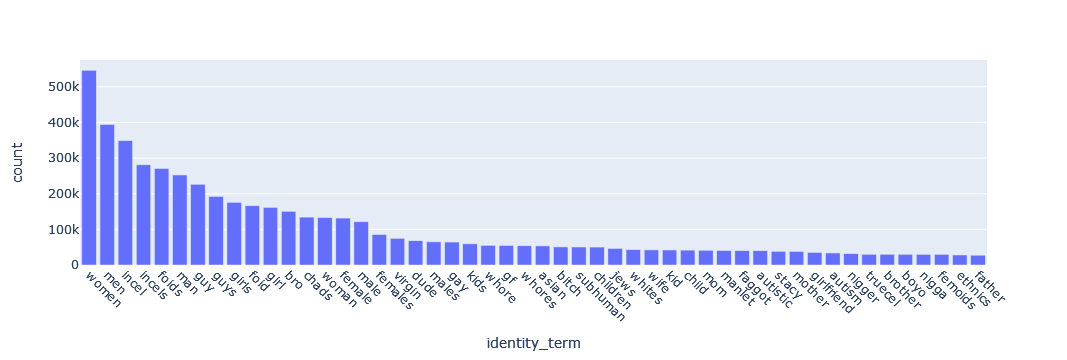

In [17]:
exp = data.explode('netmapper_identity_matches')
# freq = pd.DataFrame(exploded.netmapper_identity_matches.value_counts(), columns=['term', 'count'])

freq = exp.netmapper_identity_matches.value_counts().to_frame(name='count').reset_index(names='identity_term')
freq.head(20)

import plotly.express as px
pd.options.plotting.backend = 'plotly'

fig = px.bar(freq.head(50), x='identity_term', y='count')
fig.update_xaxes(tickangle=45)

In [18]:
# Count number of identity term mentions (top-down generic list + bottom-up)
print(exp['netmapper_identity_matches'].count())

8909464


In [4]:
# Count number of identity term mentions (top-down generic list)
print(exp['netmapper_identity_matches'].count())

6464047

In [5]:
print(len(data))

6248230

## Group identity terms

423


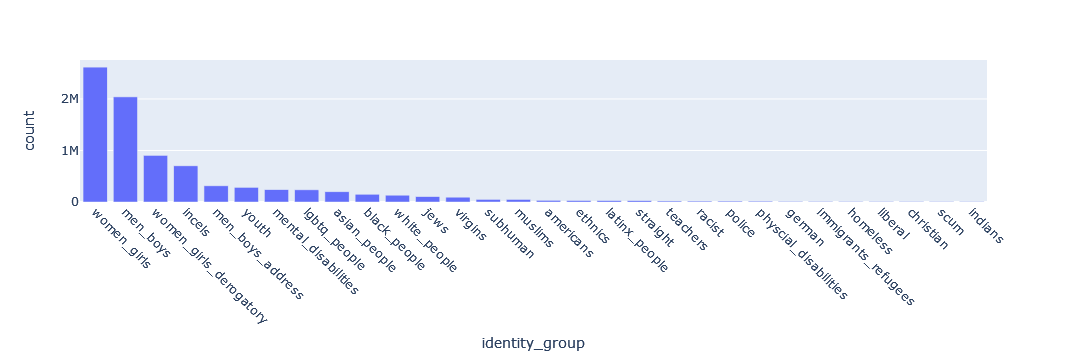

In [19]:
import json

identity_groups_fpath = '../resources/identity_groups.json'
with open(identity_groups_fpath, 'r') as f:
    identity_groups = json.load(f)
print(len(identity_groups))

exp['identity_group'] = exp.netmapper_identity_matches.map(lambda x: identity_groups.get(x, x))
exploded = exp.explode('identity_group') # Count intersectional mentions as a mention in each of their categories
gp_freq = exploded.identity_group.value_counts().to_frame(name='count').reset_index(names='identity_group')
gp_freq.head(30)

import plotly.express as px
pd.options.plotting.backend = 'plotly'

# fig = px.bar(gp_freq.head(50), x='term', y='count')
fig = px.bar(gp_freq.head(30), x='identity_group', y='count')
fig.update_xaxes(tickangle=45)

In [7]:
from collections import defaultdict

gp_vals = defaultdict(list)
for key, vals in identity_groups.items():
    for gp in vals:
        gp_vals[gp].append(key)
        
for gp, terms in gp_vals.items():
    print(f'{gp}: {terms}')

women_girls: ['women', 'woman', 'girls', 'girl', 'girlfriend', 'girlfriends', 'female', 'females', 'whore', 'whores', 'bitch', 'bitches', 'slut', 'sluts', 'cunt', 'cunts', 'prostitute', 'prostitutes', 'hooker', 'hookers', 'black women', 'feminist', 'feminists', 'white women', 'gf', 'sister', 'mother', 'daughter', 'mom', 'wife', 'wives', 'mothers']
men_boys: ['men', 'man', 'boy', 'boys', 'boyfriend', 'boyfriends', 'bro', 'dude', 'dudes', 'male', 'males', 'black men', 'white men', 'bf', 'brother', 'brothers', 'father', 'son', 'husband', 'husbands', 'fathers']
men_boys_address: ['bro', 'dude', 'dudes']
women_girls_derogatory: ['whore', 'whores', 'bitch', 'bitches', 'slut', 'sluts', 'cunt', 'cunts', 'prostitute', 'prostitutes', 'hooker', 'hookers']
youth: ['kids', 'kid', 'child', 'children', 'baby', 'babies', 'teen', 'teens']
virgins: ['virgin']
lgbtq_people: ['faggot', 'faggots', 'fag', 'fags', 'tranny', 'transgender', 'gay', 'gays', 'trans', 'bi', 'bisexual', 'bisexuals', 'pansexual', 'p

In [8]:
all_identities = exploded.netmapper_identity_matches.unique()
len(all_identities)

5460

In [9]:
for term in gp_vals['latinx_people']:
    print(f'{term}: {term in all_identities}')

spanish: True
hispanic: True
latino: True
latina: False
latinx: False
mexican: True
latin american: False
central american: False
south american: False
dominican: True
puerto rican: False
salvadoran: True
honduran: True
nicaraguan: True
costa rican: False
colombian: True
venezuelan: True
ecuadorian: True
brazilian: True
argentinian: True
bolivian: True
peruvian: True
chilean: True


In [84]:
for term in ['jew', 'jews', 'jewish', 'kike', 'kikes', 'zionist', 'zionists', 'judaism', 'israelite', 'israelites', 'goy', 'goyim']:
    print(f'{term}: {term in all_identities}')

jew: True
jews: True
jewish: False
kike: True
kikes: False
zionist: True
zionists: True
judaism: False
israelite: True
israelites: True
goy: False
goyim: False


In [134]:
for term in ['gay', 'gays', 'lesbian', 'trans', 'transgender', 'bi', 'bisexual', 'pansexual', 'homosexual', 'homo', 'queer',
            'transman', 'transwoman', 'queers', 'fag', 'fags']:
    print(f'{term}: {term in all_identities}')

gay: False
gays: True
lesbian: True
trans: False
transgender: False
bi: False
bisexual: False
pansexual: False
homosexual: True
homo: True
queer: True
transman: False
transwoman: False
queers: False
fag: True
fags: False


In [9]:
[identity for identity in all_identities if 'negro' in str(identity)]

['negroes', 'negroid', 'negro', 'negros']

In [91]:
[identity for identity in all_identities if 'white' in str(identity)]

['nonwhites', 'whiteman', 'whitetrash']

In [96]:
[identity for identity in all_identities if ' ' in str(identity)]

[]

In [104]:
[identity for identity in all_identities if 'nig' in str(identity)]

['niggers',
 'niggas',
 'nigger',
 'knight',
 'nig',
 'knights',
 'nigga',
 'niggah',
 'nigerian',
 'sandnigger',
 'niggaz',
 'knighted',
 'knightly',
 'niglet',
 'nigra',
 'knighthood',
 'nigerians',
 'nigg',
 'snownigger',
 'nigr',
 'niggur',
 'datnigga',
 'nigre']

In [103]:
import re

re.search(r'\b{}\b'.format(re.escape('black man')), 'black man walking').group()
# re.search(r'\b{}\b'.format(re.escape('black man')), 'asian man walking').group()

'black man'

### Identity groups over time

In [21]:
# For incels

from datetime import datetime, timezone

date_col = 'parsed_date' # for incels data

post_counts = data.groupby(pd.Grouper(key=date_col, freq='MS'))['content'].count()
data['word_count'] = data.content.str.split().str.len() # for incels data

word_counts = data.groupby(pd.Grouper(key=date_col, freq='MS'))['word_count'].sum()
word_counts

# exploded = data.explode('netmapper_identity_matches').dropna(subset='netmapper_identity_matches')
# counts_overtime = exploded.groupby([pd.Grouper(key=date_col, freq='MS'), 'netmapper_identity_matches']).size().to_frame(name='count').reset_index(names=[date_col, 'identity_term'])
counts_overtime = exploded.groupby([pd.Grouper(key=date_col, freq='MS'), 'identity_group']).size().to_frame(name='term_count').reset_index(names=[date_col, 'identity_group'])
counts_overtime

counts_overtime = counts_overtime.join(word_counts, on=date_col).rename(columns={'content': 'word_count'})
counts_overtime

import numpy as np

counts_overtime['mention_prob'] = counts_overtime['term_count'] / counts_overtime.word_count
counts_overtime['log_prob'] = counts_overtime['mention_prob'].map(np.log10)
counts_overtime.head()

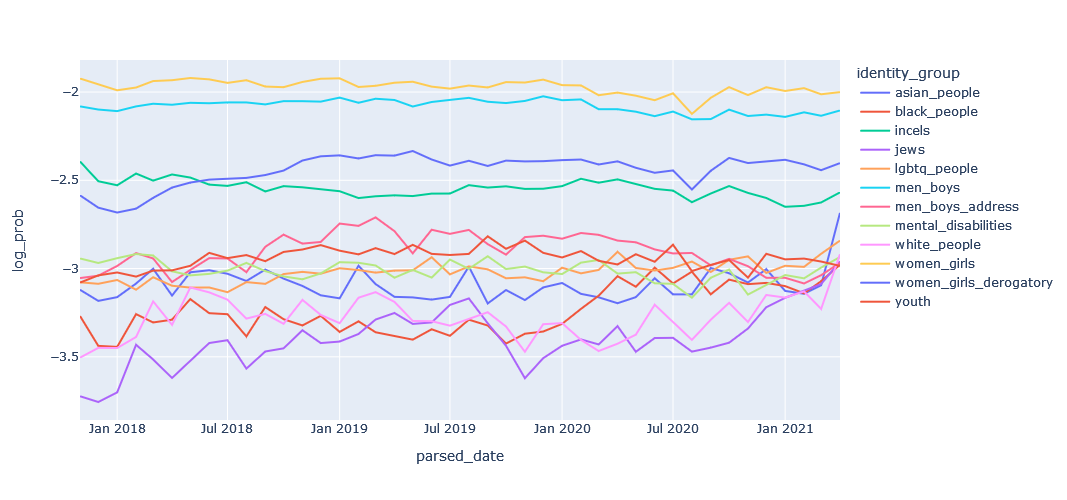

In [24]:
# Plot
import plotly.express as px

# Select only most popular identity groups
filtered = counts_overtime[counts_overtime.identity_group.isin(gp_freq.identity_group.head(12))]

# px.line(filtered, x=date_col, y='count', color='identity_term')
px.line(filtered, x=date_col, y='log_prob', color='identity_group', height=500)
# px.line(filtered, x=date_col, y='mention_prob', color='identity_group', log_y=True)

In [5]:
# For white supremacist data

from datetime import datetime, timezone

# post_counts = data.groupby(pd.Grouper(key=date_col, freq='MS'))['content'].count()
# data['word_count'] = data.content.str.split().str.len() # for incels data

date_col = 'parsed_date' # for incels data
# date_col = 'timestamp' # for white supremacist data, which has a lot of corpus composition changes during that period

# Remove outliers (for white supremacist data)
# data = data[data.timestamp >= datetime(2002, 1, 1, tzinfo=timezone.utc)]
# exploded = exploded[exploded.timestamp >= datetime(2002, 1, 1, tzinfo=timezone.utc)]

word_counts = data.groupby(pd.Grouper(key=date_col, freq='MS'))['word_count'].sum()
word_counts

# exploded = data.explode('netmapper_identity_matches').dropna(subset='netmapper_identity_matches')
# counts_overtime = exploded.groupby([pd.Grouper(key=date_col, freq='MS'), 'netmapper_identity_matches']).size().to_frame(name='count').reset_index(names=[date_col, 'identity_term'])
counts_overtime = exploded.groupby([pd.Grouper(key=date_col, freq='MS'), 'identity_group']).size().to_frame(name='term_count').reset_index(names=[date_col, 'identity_group'])
counts_overtime

counts_overtime = counts_overtime.join(word_counts, on=date_col).rename(columns={'content': 'word_count'})
counts_overtime

import numpy as np

counts_overtime['mention_prob'] = counts_overtime['term_count'] / counts_overtime.word_count
counts_overtime['log_prob'] = counts_overtime['mention_prob'].map(np.log10)
counts_overtime.head()

# Plot
import plotly.express as px

# Select only most popular identity groups
filtered = counts_overtime[counts_overtime.identity_group.isin(gp_freq.identity_group.head(11))]

# px.line(filtered, x=date_col, y='count', color='identity_term')
px.line(filtered, x=date_col, y='log_prob', color='identity_group', height=500)
# px.line(filtered, x=date_col, y='mention_prob', color='identity_group', log_y=True)

KeyError: 'Column not found: word_count'

## Look into specific time periods

In [27]:
# April 2020 jump in women_girls_derogatory and black_people
# Filter data to that month

period = exploded[(exploded.parsed_date.dt.year == 2020) & (exploded.parsed_date.dt.month == 4)]
period.info()
print(period.parsed_date.min())
print(period.parsed_date.max())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 468342 entries, 6426 to 6247022
Data columns (total 9 columns):
 #   Column                      Non-Null Count   Dtype         
---  ------                      --------------   -----         
 0   type                        468342 non-null  object        
 1   forum                       468342 non-null  object        
 2   thread                      468342 non-null  object        
 3   username                    468342 non-null  object        
 4   date                        468342 non-null  object        
 5   content                     461175 non-null  object        
 6   parsed_date                 468342 non-null  datetime64[ns]
 7   netmapper_identity_matches  277014 non-null  object        
 8   identity_group              277014 non-null  object        
dtypes: datetime64[ns](1), object(8)
memory usage: 35.7+ MB
2020-04-01 00:00:00
2020-04-30 00:00:00


In [39]:
identity_group = 'black_people'
# identity_group = 'women_girls_derogatory'
selected = period[period.identity_group == identity_group]
print(len(selected))
print(len(selected.index.unique())) # index is unique to the post

selected.index.value_counts().iloc[:20]

17608
5979


4302754    2128
4302327    2128
4302067    2128
4302518    2128
5633249     385
5632825     385
4326208     124
4326210     124
5686516      61
5687210      60
4222121      42
4222118      42
4221607      39
4254361      37
3956420      27
3956421      25
4254362      24
4254367      24
4263912      17
4276907      16
dtype: int64

In [ ]:
pd.set_option('display.max_colwidth', None)
selected.loc[4302327].iloc[0]

In [ ]:
pd.set_option('display.max_colwidth', None)
selected.loc[1045225].iloc[0]

## Identity categories

In [25]:
import json

identity_cats_fpath = '../resources/identity_categories.json'
with open(identity_cats_fpath, 'r') as f:
    identity_cats = json.load(f)
print(len(identity_cats))

exploded['identity_category'] = exploded.identity_group.map(identity_cats)
cat_freq = exploded.identity_category.value_counts()
cat_freq

433


gender/sexuality    4983067
race/ethnicity       546530
age                  298246
religion             207057
politics              69029
disability             3426
Name: identity_category, dtype: int64

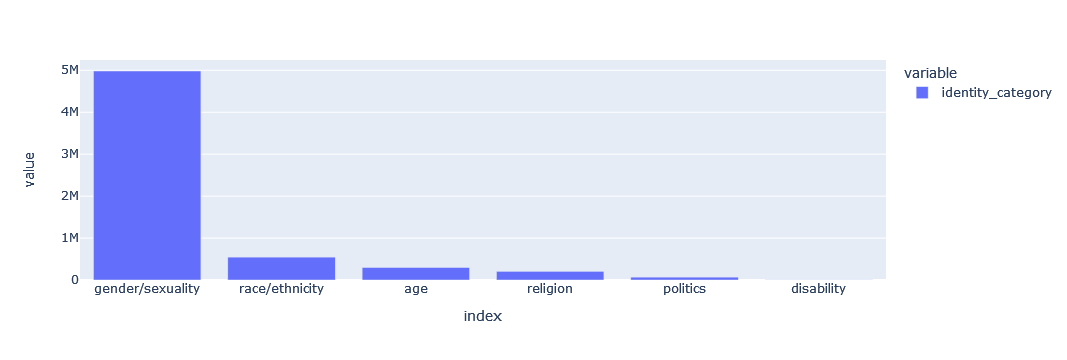

In [26]:
import plotly.express as px
pd.options.plotting.backend = 'plotly'

fig = px.bar(cat_freq)
fig.show()

In [33]:
from collections import defaultdict

cat_vals = defaultdict(list)
for key, val in identity_cats.items():
    cat_vals[val].append(key)
        
for cat, terms in cat_vals.items():
    print(f'{cat}: {terms}')

race/ethnicity: ['black_people', 'asian_people', 'white_people']
gender/sexuality: ['men_boys', 'women_girls', 'lgbtq_people']
age: ['youth', 'boomers']
disability: ['retard']
religion: ['jews', 'muslims', 'christian', 'hindus', 'buddhists']
politics: ['liberal', 'conservative']


### Identity categories over time

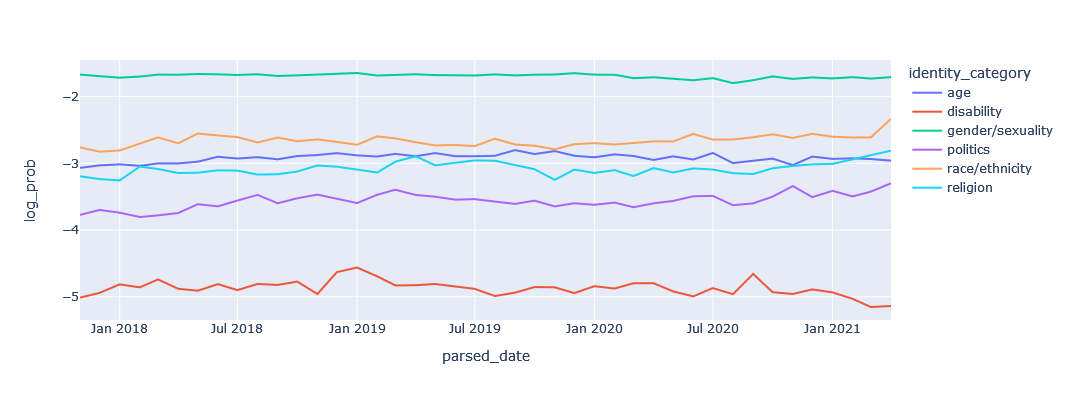

In [27]:
# post_counts = data.groupby(pd.Grouper(key='parsed_date', freq='MS'))['content'].count()
# data['word_count'] = data.content.str.split().str.len() # already done from identity grouping

word_counts = data.groupby(pd.Grouper(key='parsed_date', freq='MS'))['word_count'].sum()
word_counts

counts_overtime = exploded.groupby([pd.Grouper(key='parsed_date', freq='MS'), 'identity_category']).size().to_frame(name='mention_count').reset_index(names=['parsed_date', 'identity_category'])
counts_overtime

counts_overtime = counts_overtime.join(word_counts, on='parsed_date').rename(columns={'content': 'word_count'})
counts_overtime

import numpy as np

counts_overtime['mention_prob'] = counts_overtime['mention_count'] / counts_overtime.word_count
counts_overtime['log_prob'] = counts_overtime['mention_prob'].map(np.log10)
counts_overtime

# Plot
import plotly.express as px

px.line(counts_overtime, x='parsed_date', y='log_prob', color='identity_category', height=400)

# Old/1-time

In [96]:
# Filter out capitalized terms (unnecessary now)
identity_cats = {term: cat for term, cat in identity_cats.items() if term[0].islower()}
len(identity_cats)

723

In [3]:
# Load data with identity matches
import pandas as pd

path = '../../data/incels/processed_comments.jsonl'
data = pd.read_json(path, lines=True, convert_dates=['parsed_date'])
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6248230 entries, 0 to 6248229
Data columns (total 8 columns):
 #   Column                                 Dtype         
---  ------                                 -----         
 0   type                                   object        
 1   forum                                  object        
 2   thread                                 object        
 3   username                               object        
 4   date                                   object        
 5   content                                object        
 6   parsed_date                            datetime64[ns]
 7   {self.identity_list}_identity_matches  object        
dtypes: datetime64[ns](1), object(7)
memory usage: 381.4+ MB


In [4]:
data.rename(columns={'{self.identity_list}_identity_matches': 'netmapper_identity_matches'}, inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6248230 entries, 0 to 6248229
Data columns (total 8 columns):
 #   Column                      Dtype         
---  ------                      -----         
 0   type                        object        
 1   forum                       object        
 2   thread                      object        
 3   username                    object        
 4   date                        object        
 5   content                     object        
 6   parsed_date                 datetime64[ns]
 7   netmapper_identity_matches  object        
dtypes: datetime64[ns](1), object(7)
memory usage: 381.4+ MB


In [5]:
data.to_pickle('../../data/incels/processed_comments.pkl')